## 1. Importing important price data
<p>Every time I go to the supermarket, my wallet weeps a little. But how expensive is food around the world? In this notebook, we'll explore time series of food prices in Rwanda from the <a href="https://data.humdata.org/dataset/wfp-food-prices">United Nations Humanitarian Data Exchange Global Food Price Database</a>. Agriculture makes up over 30% of Rwanda's economy, and over 60% of its export earnings (<a href="https://www.cia.gov/library/publications/the-world-factbook/geos/rw.html">CIA World Factbook</a>), so the price of food is very important to the livelihood of many Rwandans.</p>
<p>The map below shows the layout of Rwanda; it is split into five administrative regions. The central area around the Captial city, Kigali, is one region, and the others are North, East, South, and West.</p>
<p><img src="https://s3.amazonaws.com/assets.datacamp.com/production/project_515/img/RwandaGeoProvinces.png" alt="A map of the five administrative regions of Rwanda"></p>
<p>In this notebook, we're going to import, manipulate, visualize and forecast Rwandan potato price data. We'll also wrap our analysis into functions to make it easy to analyze prices of other foods.</p>

In [2]:
# Load the readr and dplyr packages
library(readr)
library(dplyr)

# Import the potatoes dataset
potato_prices <- read_csv("datasets/Potatoes (Irish).csv")

# Take a glimpse at the contents
glimpse(potato_prices)


Attaching package: 'dplyr'

The following objects are masked from 'package:stats':

    filter, lag

The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union

Parsed with column specification:
cols(
  adm0_id = col_integer(),
  adm0_name = col_character(),
  adm1_id = col_integer(),
  adm1_name = col_character(),
  mkt_id = col_integer(),
  mkt_name = col_character(),
  cm_id = col_integer(),
  cm_name = col_character(),
  cur_id = col_integer(),
  cur_name = col_character(),
  pt_id = col_integer(),
  pt_name = col_character(),
  um_id = col_integer(),
  um_name = col_character(),
  mp_month = col_integer(),
  mp_year = col_integer(),
  mp_price = col_double(),
  mp_commoditysource = col_character()
)


Observations: 4,320
Variables: 18
$ adm0_id            <int> 205, 205, 205, 205, 205, 205, 205, 205, 205, 205...
$ adm0_name          <chr> "Rwanda", "Rwanda", "Rwanda", "Rwanda", "Rwanda"...
$ adm1_id            <int> 21973, 21973, 21973, 21973, 21973, 21973, 21973,...
$ adm1_name          <chr> "$West/Iburengerazuba", "$West/Iburengerazuba", ...
$ mkt_id             <int> 1045, 1045, 1045, 1045, 1045, 1045, 1045, 1045, ...
$ mkt_name           <chr> "Birambo", "Birambo", "Birambo", "Birambo", "Bir...
$ cm_id              <int> 148, 148, 148, 148, 148, 148, 148, 148, 148, 148...
$ cm_name            <chr> "Potatoes (Irish)", "Potatoes (Irish)", "Potatoe...
$ cur_id             <int> 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, ...
$ cur_name           <chr> "RWF", "RWF", "RWF", "RWF", "RWF", "RWF", "RWF",...
$ pt_id              <int> 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, ...
$ pt_name            <chr> "Retail", "Retail", "Retail", "Retail", "Retail"...
$ um_id           

## 2. Once more, with feeling
<p>Many of the columns in the potato data aren't very useful for our analysis. For example, the <code>adm1_name</code> column is always <code>"Rwanda"</code>, and <code>cur_name</code> is always <code>"RWF"</code>. (This is short for Rwandan Franc; for context, 1000 RWF is a little over 1 USD.) Similarly, we don't really need any of the ID columns or the data source.</p>
<p>Even the columns we do need have slightly obscure names. For example, <code>adm1_id</code> isn't as clear as <code>region</code>, and <code>mkt_name</code> isn't as clear as <code>market</code>. One of the most types of data analysis disaster is to misunderstand what a variable means, so naming variable clearly is a useful way to avoid this. One trick is that any variable that includes a unit should include that unit in the variable name. Here, the prices are given in Rwandan Francs, so <code>price_rwf</code> is a good name.</p>

In [4]:
# Import again, only reading specific columns
# .... YOUR CODE FOR TASK 2 ..
potato_prices <- read_csv("datasets/Potatoes (Irish).csv", 
                          col_types= cols_only(
                              adm1_name = col_character(),
                              mkt_name = col_character(),
                              cm_name = col_character(),
                              mp_month = col_number(),
                              mp_year = col_number(),
                              mp_price = col_number()))

# Rename the columns to be more informative
potato_vector <- c("region" = "adm1_name",
                   "market" = "mkt_name",
                   "commodity_kg" = "cm_name",
                   "month" = "mp_month",
                   "year" = "mp_year",
                   "price_rwf" = "mp_price")


names(potato_prices) <- c("region", 
                          "market", 
                          "commodity_kg", 
                          "month", 
                          "year", 
                          "price_rwf")
# .... YOUR CODE FOR TASK 2 ....
potato_prices_renamed <- potato_prices
# Check the result
glimpse(potato_prices_renamed)

Observations: 4,320
Variables: 6
$ region       <chr> "$West/Iburengerazuba", "$West/Iburengerazuba", "$West...
$ market       <chr> "Birambo", "Birambo", "Birambo", "Birambo", "Birambo",...
$ commodity_kg <chr> "Potatoes (Irish)", "Potatoes (Irish)", "Potatoes (Iri...
$ month        <dbl> 11, 12, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 1, 2, 3...
$ year         <dbl> 2010, 2010, 2011, 2011, 2011, 2011, 2011, 2011, 2011, ...
$ price_rwf    <dbl> 157.0000, 133.3333, 96.5000, 97.0000, 107.8000, 125.50...


## 3. Spring cleaning
<p>As is often the case in a data analysis, the data we are given isn't in quite the form we'd like it to be. For example, we may have noticed in the last task that the month and year given as integers. Since we'll be performing some time series analysis, it would be helpful if they were provided as dates. Before we can analyze the data, we need to spring clean it.</p>

In [6]:
# Load lubridate
library(lubridate)

potato_prices_cleaned <- potato_prices_renamed %>% 
    mutate(date=ymd(paste(year, month, '01'))) %>% 
    select(-year, -month)


# See the result
potato_prices_cleaned


Attaching package: 'lubridate'

The following object is masked from 'package:base':

    date



region,market,commodity_kg,price_rwf,date
$West/Iburengerazuba,Birambo,Potatoes (Irish),157.0000,2010-11-01
$West/Iburengerazuba,Birambo,Potatoes (Irish),133.3333,2010-12-01
$West/Iburengerazuba,Birambo,Potatoes (Irish),96.5000,2011-01-01
$West/Iburengerazuba,Birambo,Potatoes (Irish),97.0000,2011-02-01
$West/Iburengerazuba,Birambo,Potatoes (Irish),107.8000,2011-03-01
$West/Iburengerazuba,Birambo,Potatoes (Irish),125.5000,2011-04-01
$West/Iburengerazuba,Birambo,Potatoes (Irish),142.0000,2011-05-01
$West/Iburengerazuba,Birambo,Potatoes (Irish),157.2500,2011-06-01
$West/Iburengerazuba,Birambo,Potatoes (Irish),134.7500,2011-07-01
$West/Iburengerazuba,Birambo,Potatoes (Irish),115.6000,2011-08-01


## 4. Potatoes are not a balanced diet
<p>As versatile as potatoes are, with their ability to be boiled, roasted, mashed, fried, or chipped, the people of Rwanda have more varied culinary tastes. That means you are going to have to look at some other food types!</p>
<p>If we want to do a similar task many times, we could just cut and paste our code and change bits here and there. This is a terrible idea, since changing code in one place doesn't keep it up to date in the other places, and we quickly end up with lots of bugs.</p>
<p>A better idea is to write a function. That way we avoid cut and paste errors and can have more readable code.</p>

In [8]:
# Wrap this code into a function
read_price_data <- function(commodity){
    file_name = paste0('datasets/', commodity, '.csv')
    
    prices <- read_csv(file_name,  col_types = cols_only(adm1_name = col_character(),
                                                         mkt_name = col_character(),
                                                         cm_name = col_character(),
                                                         mp_month = col_integer(),
                                                         mp_year = col_integer(),
                                                         mp_price = col_double()))
    prices_renamed <- prices %>% rename(region = adm1_name, 
                                               market = mkt_name,
                                               commodity_kg = cm_name,
                                               month = mp_month,
                                               year = mp_year,
                                               price_rwf = mp_price)
    prices_cleaned <- prices_renamed %>% 
                            mutate(date = ymd(paste(year, month, "01"))) %>% 
                            select(-month, -year)
}

# Test it
pea_prices <- read_price_data('Peas (fresh)')
glimpse(pea_prices)

Observations: 1,893
Variables: 5
$ region       <chr> "$West/Iburengerazuba", "$West/Iburengerazuba", "$West...
$ market       <chr> "Birambo", "Birambo", "Birambo", "Birambo", "Birambo",...
$ commodity_kg <chr> "Peas (fresh)", "Peas (fresh)", "Peas (fresh)", "Peas ...
$ price_rwf    <dbl> 403.5000, 380.0000, 277.5000, 450.0000, 450.0000, 375....
$ date         <date> 2011-01-01, 2011-02-01, 2011-04-01, 2011-05-01, 2011-...


## 5. Plotting the price of potatoes
<p>A great first step in any data analysis is to look at the data. In this case, we have some prices, and we have some dates, so the obvious thing to do is to see how those prices change over time.</p>

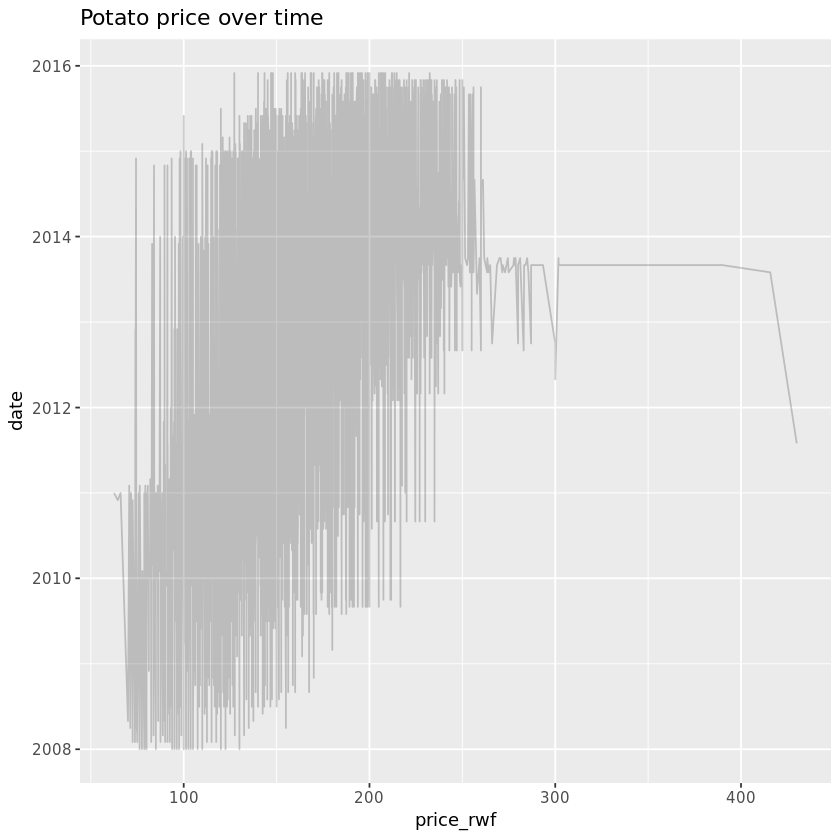

In [10]:
# Load ggplot2
library(ggplot2)

# Draw a line plot of price vs. date grouped by market 
ggplot(potato_prices_cleaned, aes(x=date, y=price_rwf, group=market)) +
    geom_line(alpha=0.2) +
    labs(title = "Potato price over time")

## 6. What a lotta plots
<p>There is a bit of a trend in the potato prices, with them increasing until 2013, after which they level off. More striking though is the seasonality: the prices are lowest around December and January, and have a peak around August. Some years also show a second peak around April or May.</p>
<p>Just as with the importing and cleaning code, if we want to make lots of similar plots, we need to wrap the plotting code into a function.</p>

In [12]:
# Wrap this code into a function
plot_price_vs_time <- function(prices, commodity){
     prices %>% 
        ggplot(aes(date, price_rwf, group = market)) +
        geom_line(alpha = 0.2) +
        ggtitle(paste0(commodity, " price over time"))
}


# Try the function on the pea data
plot_price_vs_time(pea_prices, 'Pea')

region,market,commodity_kg,price_rwf,date
$West/Iburengerazuba,Birambo,Potatoes (Irish),157.0000,2010-11-01
$West/Iburengerazuba,Birambo,Potatoes (Irish),133.3333,2010-12-01
$West/Iburengerazuba,Birambo,Potatoes (Irish),96.5000,2011-01-01
$West/Iburengerazuba,Birambo,Potatoes (Irish),97.0000,2011-02-01
$West/Iburengerazuba,Birambo,Potatoes (Irish),107.8000,2011-03-01
$West/Iburengerazuba,Birambo,Potatoes (Irish),125.5000,2011-04-01
$West/Iburengerazuba,Birambo,Potatoes (Irish),142.0000,2011-05-01
$West/Iburengerazuba,Birambo,Potatoes (Irish),157.2500,2011-06-01
$West/Iburengerazuba,Birambo,Potatoes (Irish),134.7500,2011-07-01
$West/Iburengerazuba,Birambo,Potatoes (Irish),115.6000,2011-08-01


## 7. Preparing to predict the future (part 1)
<p>While it's useful to see how the prices have changed in the past, what's more exciting is to forecast how they will change in the future. Before we get to that, there are some data preparation steps that need to be performed.</p>
<p>The datasets for each commodity are very rich: rather than being a single time series, they consist of a time series for each market. The fancy way of analyzing this is to treat it as a single hierarchical time series. The easier way that we'll try here, is to take the average price across markets at each time and analyze the resulting single time series.</p>
<p>Looking at the plots from the potato and pea datasets, we can see that occasionally there is a big spike in the price. That probably indicates a logistic problem where that food wasn't easily available at a particular market, or the buyer looked like a tourist and got ripped off. The consequence of these outliers is that it is a bad idea to use the <em>mean</em> price of each time point: instead, the <em>median</em> makes more sense since it is robust against outliers.</p>

In [14]:
# Group by date, and calculate the median price
potato_prices_summarized <- potato_prices_cleaned %>% 
    group_by(date) %>% 
    summarize(median_price_rwf=median(price_rwf))

# See the result
potato_prices_summarized

region,market,commodity_kg,price_rwf,date,median_price_rwf
$West/Iburengerazuba,Birambo,Potatoes (Irish),157.0000,2010-11-01,151.5000
$West/Iburengerazuba,Birambo,Potatoes (Irish),133.3333,2010-12-01,122.5000
$West/Iburengerazuba,Birambo,Potatoes (Irish),96.5000,2011-01-01,105.7000
$West/Iburengerazuba,Birambo,Potatoes (Irish),97.0000,2011-02-01,108.1750
$West/Iburengerazuba,Birambo,Potatoes (Irish),107.8000,2011-03-01,118.8750
$West/Iburengerazuba,Birambo,Potatoes (Irish),125.5000,2011-04-01,145.0143
$West/Iburengerazuba,Birambo,Potatoes (Irish),142.0000,2011-05-01,148.6667
$West/Iburengerazuba,Birambo,Potatoes (Irish),157.2500,2011-06-01,148.0500
$West/Iburengerazuba,Birambo,Potatoes (Irish),134.7500,2011-07-01,137.4048
$West/Iburengerazuba,Birambo,Potatoes (Irish),115.6000,2011-08-01,137.2619


## 8. Preparing to predict the future (part 2)
<p>Time series analysis in R is at a crossroads. The best and most mature tools for analysis are based around a time series data type called <code>ts</code>, which predates the tidyverse by several decades. That means that we have to do one more data preparation step before we can start forecasting: we need to convert our summarized dataset into a <code>ts</code> object.</p>

In [16]:
# Load magrittr
library(magrittr)

max_date = max(potato_prices_summarized$date)
min_date = min(potato_prices_summarized$date)

# Extract a time series
potato_time_series <- ts(potato_prices_summarized$median_price_rwf, 
                         end=c(year(max_date), month(max_date)),
                         start=c(year(min_date), month(min_date)),
                         frequency=12)

# See the result
potato_time_series


Attaching package: 'magrittr'

The following objects are masked from 'package:testthat':

    equals, is_less_than, not



[1] 151.5000 122.5000 105.7000 108.1750 118.8750 145.0143 148.6667 148.0500
   [9] 137.4048 137.2619 141.6667 144.2000 133.1750 141.5000 150.7500 175.2500
  [17] 186.0139 186.2500 182.5000 162.7500 179.1250 196.9643 226.5000 203.5000
  [25] 169.2500 144.0000 154.3333 157.0000 171.2500 187.5000 177.0000 202.2500
  [33] 210.0000 233.1875 241.3333 237.5000 176.7083 140.0000 138.3333 158.7500
  [41] 186.2500 198.2500 191.0000 189.3333 182.5000 187.6191 200.0000 183.1310
  [49] 150.0000 133.9286 136.2500 157.6071 178.0000 190.2778 179.3750 168.3333
  [57] 180.0000 202.1250 223.5000 217.5000 216.1250 190.0000  97.5000 100.0000
  [65]  95.0000  96.2500  95.0000 110.0000 116.6667 125.0000 136.2500 130.0000
  [73] 127.5000 114.3750 120.0000 122.5000 130.0000 131.2500 135.0000 124.3125
  [81] 125.8333 144.2500 181.2500 170.0000 150.2500 112.0000 109.6875 113.5000
  [89] 131.2500 132.0833 140.4167 147.3750 142.5000 161.5000 182.4000 151.5000
  [97] 122.5000 105.7000 108.1750 118.8750 145.0143 148.6667 148.0500 137.4048
 [105] 137.2619 141.6667 144.2000 133.1750 141.5000 150.7500 175.2500 186.0139
 [113] 186.2500 162.7500 179.1250 196.9643 203.5000 169.2500 144.0000 154.3333
 [121] 157.0000 171.2500 187.5000 177.0000 202.2500 210.0000 233.1875 241.3333
 [129] 237.5000 176.7083 140.0000 138.3333 158.7500 186.2500 198.2500 191.0000
 [137] 189.3333 182.5000 187.6191 200.0000 150.0000 133.9286 136.2500 157.6071
 [145] 178.0000 190.2778 179.3750 168.3333 180.0000 202.1250 223.5000 217.5000
 [153] 216.1250 190.0000  97.5000 100.0000  95.0000  96.2500  95.0000 110.0000
 [161] 116.6667 125.0000 136.2500 127.5000 114.3750 120.0000 122.5000 130.0000
 [169] 131.2500 135.0000 124.3125 125.8333 144.2500 181.2500 170.0000 150.2500
 [177] 112.0000 109.6875 113.5000 131.2500 132.0833 140.4167 147.3750 142.5000
 [185] 161.5000 182.4000 162.5000 151.5000 122.5000 105.7000 108.1750 118.8750
 [193] 145.0143 148.6667 148.0500 137.4048 137.2619 141.6667 144.2000 133.1750
 [201] 141.5000 150.7500 175.2500 186.0139 186.2500 182.5000 162.7500 179.1250
 [209] 196.9643 226.5000 203.5000 169.2500 144.0000 154.3333 157.0000 171.2500
 [217] 187.5000 177.0000 202.2500 210.0000 233.1875 241.3333 237.5000 176.7083
 [225] 140.0000 138.3333 158.7500 186.2500 198.2500 191.0000 189.3333 182.5000
 [233] 187.6191 200.0000 150.0000 133.9286 136.2500 157.6071 178.0000 190.2778
 [241] 179.3750 168.3333 180.0000 202.1250 223.5000 217.5000 216.1250 190.0000
 [249]  97.5000 100.0000  95.0000  96.2500  95.0000 110.0000 116.6667 125.0000
 [257] 136.2500 130.0000 127.5000 114.3750 120.0000 122.5000 130.0000 131.2500
 [265] 135.0000 124.3125 125.8333 144.2500 181.2500 170.0000 150.2500 112.0000
 [273] 109.6875 113.5000 131.2500 132.0833 140.4167 147.3750 142.5000 161.5000
 [281] 182.4000 162.5000 151.5000 122.5000 105.7000 108.1750 118.8750 145.0143
 [289] 148.6667 148.0500 137.4048 137.2619 141.6667 144.2000 133.1750 141.5000
 [297] 150.7500 175.2500 186.0139 186.2500 182.5000 162.7500 179.1250 196.9643
 [305] 226.5000 203.5000 169.2500 144.0000 154.3333 157.0000 171.2500 187.5000
 [313] 177.0000 202.2500 210.0000 233.1875 241.3333 237.5000 176.7083 140.0000
 [321] 138.3333 158.7500 186.2500 198.2500 191.0000 189.3333 182.5000 187.6191
 [329] 200.0000 183.1310 150.0000 133.9286 136.2500 157.6071 178.0000 190.2778
 [337] 179.3750 168.3333 180.0000 202.1250 223.5000 217.5000 216.1250 190.0000
 [345]  97.5000 100.0000  95.0000  96.2500  95.0000 110.0000 116.6667 125.0000
 [353] 136.2500 130.0000 127.5000 114.3750 120.0000 122.5000 130.0000 131.2500
 [361] 135.0000 124.3125 125.8333 144.2500 181.2500 170.0000 150.2500 112.0000
 [369] 109.6875 113.5000 131.2500 132.0833 140.4167 147.3750 142.5000 161.5000
 [377] 182.4000 151.5000 122.5000 105.7000 108.1750 118.8750 145.0143 148.6667
 [385] 148.0500 137.4048 137.2619 141.6667 144.2000 133.1750 141.5000 150.7500
 [393] 175.2500 186.0139 186.2500 182.5000 162.7500 179.1250 226.5000 203.5000
 [401] 169.2500 144.0000 154.3333 157.0000 171.2500 1

## 9. Another day, another function to write
<p>Those data preparation steps were tricky! Wouldn't it be really nice if we never had to write them again? Well, if we wrap that code into a function, then we won't have to.</p>

In [18]:
# Wrap this code into a function
create_price_time_series <- function(prices){
    prices_summarized <- prices %>%
        group_by(date) %>% 
        summarize(median_price_rwf = median(price_rwf))

    time_series <- prices_summarized %$% 
          ts(median_price_rwf, 
            start = c(year(min(date)), month(min(date))), 
            end   = c(year(max(date)), month(max(date))), 
            frequency = 12)
}



# Try the function on the pea data
pea_time_series <- create_price_time_series(pea_prices)
pea_time_series

function (data = NA, start = 1, end = numeric(), frequency = 1, 
    deltat = 1, ts.eps = getOption("ts.eps"), class = if (nseries > 
        1) c("mts", "ts", "matrix") else "ts", names = if (!is.null(dimnames(data))) colnames(data) else paste("Series", 
        seq(nseries))) 
{
    if (is.data.frame(data)) 
        data <- data.matrix(data)
    if (is.matrix(data)) {
        nseries <- ncol(data)
        ndata <- nrow(data)
        dimnames(data) <- list(NULL, names)
    }
    else {
        nseries <- 1
        ndata <- length(data)
    }
    if (ndata == 0) 
        stop("'ts' object must have one or more observations")
    if (missing(frequency)) 
        frequency <- 1/deltat
    else if (missing(deltat)) 
        deltat <- 1/frequency
    if (frequency > 1 && abs(frequency - round(frequency)) < 
        ts.eps) 
        frequency <- round(frequency)
    if (length(start) > 1L) {
        start <- start[1L] + (start[2L] - 1)/frequency
    }
    if (length(end) > 1L) {
        end <- end[1L] + (end[2L] - 1)/frequency
    }
    if (missing(end)) 
        end <- start + (ndata - 1)/frequency
    else if (missing(start)) 
        start <- end - (ndata - 1)/frequency
    if (start > end) 
        stop("'start' cannot be after 'end'")
    nobs <- floor((end - start) * frequency + 1.01)
    if (nobs != ndata) 
        data <- if (NCOL(data) == 1) {
            if (ndata < nobs) 
                rep_len(data, nobs)
            else if (ndata > nobs) 
                data[1L:nobs]
        }
        else {
            if (ndata < nobs) 
                data[rep_len(1L:ndata, nobs), ]
            else if (ndata > nobs) 
                data[1L:nobs, ]
        }
    attr(data, "tsp") <- c(start, end, frequency)
    if (!is.null(class) && class != "none") 
        attr(data, "class") <- class
    data
}
<bytecode: 0x62ed738>
<environment: namespace:stats>

## 10. The future of potato prices
<p>All the preparation is done and we are ready to start forecasting. One question we might ask is "how do I know if I can trust our forecast?". Recall that both the potato and the pea data had strong seasonality (for example, potatoes were most expensive around August and cheapest around December). For agricultural data, a good forecast should show a similar shape throughout the seasons.</p>
<p>Now then, are we ready to see the future?</p>

     Point Forecast    Lo 80    Hi 80     Lo 95    Hi 95
4321       191.6149 163.2355 219.9944 148.21235 235.0175
4322       193.2271 152.7901 233.6641 131.38407 255.0702
4323       194.8393 144.9406 244.7380 118.52584 271.1527
4324       196.4515 138.3995 254.5034 107.66868 285.2343
4325       198.0636 132.6721 263.4552  98.05586 298.0714
4326       199.6758 127.5063 271.8453  89.30213 310.0495
4327       201.2880 122.7538 279.8222  81.18026 321.3957
4328       202.9002 118.3182 287.4821  73.54321 332.2571
4329       204.5123 114.1333 294.8914  66.28952 342.7351
4330       206.1245 110.1511 302.0979  59.34579 352.9032

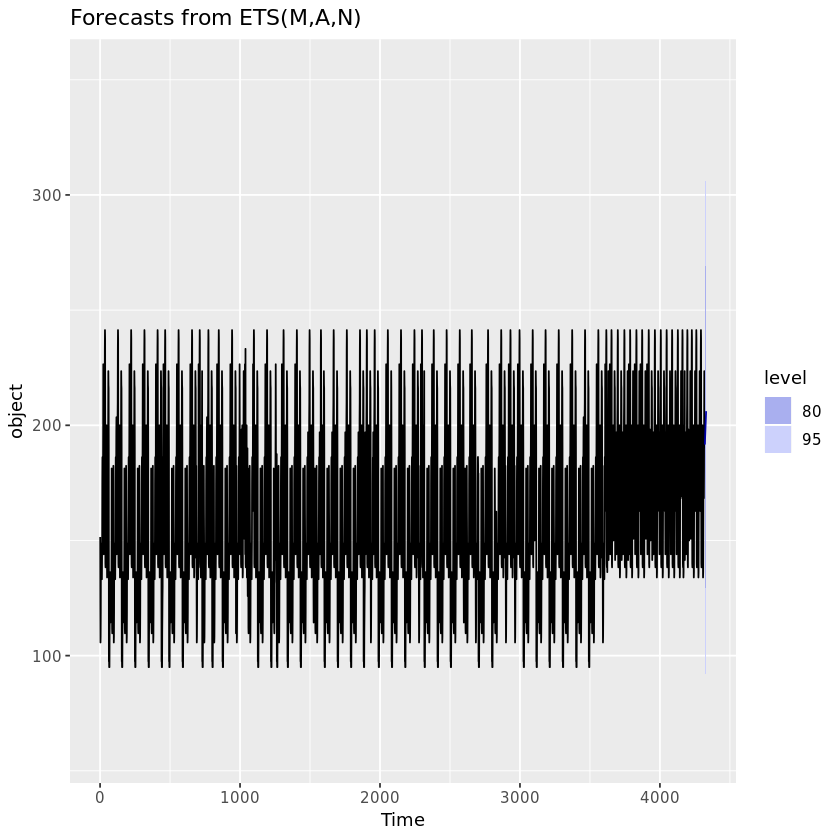

In [20]:
# Load forecast
library(forecast)

# Forecast the potato time series
potato_price_forecast <- forecast(potato_time_series)

# View it
potato_price_forecast

# Plot the forecast
autoplot(potato_price_forecast, main='Potato price forecast'

## 11. The final function
<p>Nice! The forecast shows the spike in potato prices in late summer and the dip toward the end of the year.</p>
<p>With this analysis step, just as the previous steps, to make things repeatable, we need to wrap the code into a function.</p>

In [22]:

# Wrap the code into a function
plot_price_forecast <- function(time_series, commodity){
    
    price_forecast <- forecast(time_series)
    autoplot(price_forecast, 
             main = paste0(commodity, " price forecast"))
}

# Try the function on the pea data
plot_price_forecast(pea_time_series, 'Pea')

## 12. Do it all over again
<p>That was a lot of effort writing all that code to analyze the potato data. Fortunately, since we wrapped all the code into functions, we can easily take a look at any other food type.</p>

In [ ]:
# Choose dry beans as the commodity
commodity <- "Beans (dry)"

# Read the price data
bean_prices <- read_price_data('Beans (dry)')

# Plot price vs. time
plot_price_vs_time(bean_prices, 'Bean')

# Create a price time series
bean_time_series <- create_price_time_series(bean_prices)

# Plot the price forecast
plot_price_forecast(bean_time_series, 'Bean')